In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, precision_recall_fscore_support)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import plot_model

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-10-21 17:37:49.128593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761068269.369935      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761068269.441141      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import numpy as np

# Change the path to point to the Kaggle input directory if on Kaggle.
KAGGLE_DATA_PATH = '/kaggle/input/ecg-data1/ecg_mitdb_processed.npz'

print("Loading preprocessed data from Kaggle Input...")
data = np.load(KAGGLE_DATA_PATH)
X = data['X']
y = data['y']
label_names = data['label_names']

print(f"Data shape: X={X.shape}, y={y.shape}")
print(f"Classes: {label_names}")

Loading preprocessed data from Kaggle Input...
Data shape: X=(112559, 250, 1), y=(112559, 5)
Classes: ['F' 'N' 'Q' 'S' 'V']


In [3]:
print("\nSplitting data...")
# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y.argmax(axis=1)
)

# Second split: 80% train, 20% validation (of the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp.argmax(axis=1)
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")



Splitting data...
Train set: 72037 samples
Validation set: 18010 samples
Test set: 22512 samples


In [4]:
def create_lstm_model(input_shape, num_classes):
    """
    Create a Bidirectional LSTM model for ECG classification.
    """
    model = models.Sequential([
        # First Bi-LSTM layer with return sequences
        layers.Bidirectional(
            layers.LSTM(128, return_sequences=True),
            input_shape=input_shape
        ),
        layers.Dropout(0.4),
        layers.BatchNormalization(),

        # Second Bi-LSTM layer
        layers.Bidirectional(layers.LSTM(64)),
        layers.Dropout(0.4),
        layers.BatchNormalization(),

        # Dense layers for classification
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# --- Model Configuration ---

input_shape = (X_train.shape[1], X_train.shape[2])  # (250, 1)
num_classes = y_train.shape[1]

# Callbacks for smart training
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# --- Create, Compile, and Train Model ---

print("\nBuilding model...")
model = create_lstm_model(input_shape, num_classes)



Building model...


I0000 00:00:1761068305.632002      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761068305.632757      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)


In [6]:
print("\nTraining model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100, # Train for longer, EarlyStopping will handle it
    batch_size=256,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Training model...
Epoch 1/100


I0000 00:00:1761068322.600633      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


282/282 ━━━━━━━━━━━━━━━━━━━━ 40s 108ms/step - accuracy: 0.7420 - loss: 0.7885 - precision: 0.8033 - recall: 0.6606 - val_accuracy: 0.8185 - val_loss: 0.5188 - val_precision: 0.8351 - val_recall: 0.7974 - learning_rate: 0.0010
Epoch 2/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - accuracy: 0.8748 - loss: 0.4120 - precision: 0.8981 - recall: 0.8444 - val_accuracy: 0.9257 - val_loss: 0.2525 - val_precision: 0.9509 - val_recall: 0.9002 - learning_rate: 0.0010
Epoch 3/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - accuracy: 0.9149 - loss: 0.2979 - precision: 0.9357 - recall: 0.8928 - val_accuracy: 0.9458 - val_loss: 0.1848 - val_precision: 0.9629 - val_recall: 0.9287 - learning_rate: 0.0010
Epoch 4/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - accuracy: 0.9319 - loss: 0.2445 - precision: 0.9481 - recall: 0.9162 - val_accuracy: 0.9394 - val_loss: 0.1828 - val_precision: 0.9536 - val_recall: 0.9244 - learning_rate: 0.0010
Epoch 5/100
282/282 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - ac

In [7]:
print("\nSaving model...")
model.save('ecg_classifier.keras')
print("Model saved successfully!")


Saving model...
Model saved successfully!



Plotting training history...
Training history saved to: training_history.png


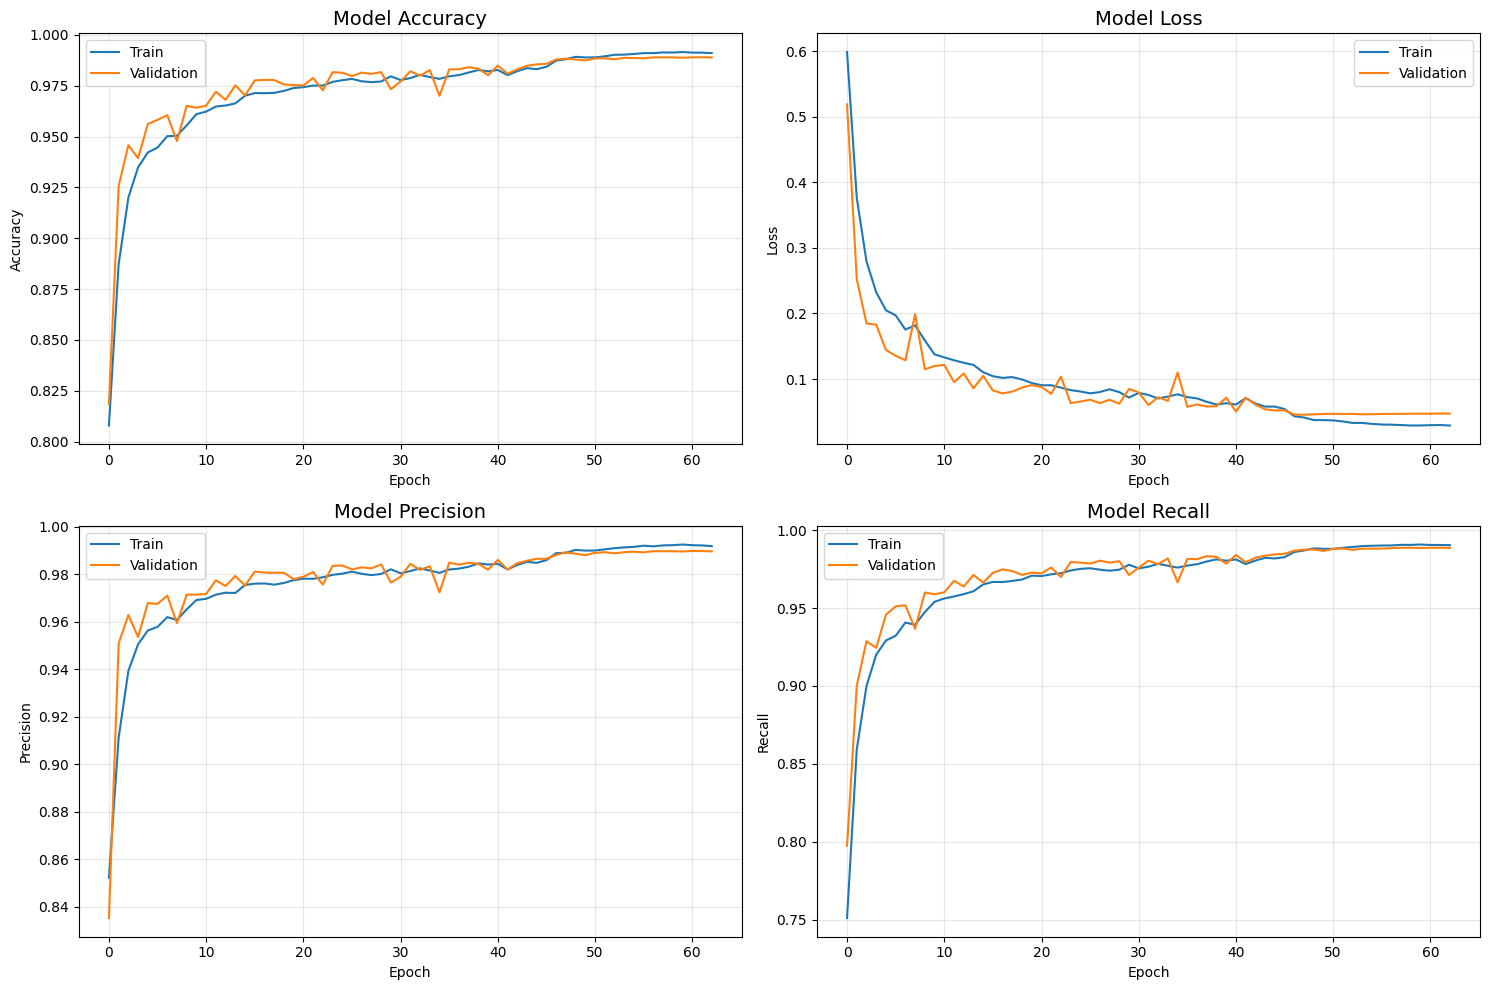

In [8]:
print("\nPlotting training history...")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation')
axes[0, 0].set_title('Model Accuracy', fontsize=14)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train')
axes[0, 1].plot(history.history['val_loss'], label='Validation')
axes[0, 1].set_title('Model Loss', fontsize=14)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train')
axes[1, 0].plot(history.history['val_precision'], label='Validation')
axes[1, 0].set_title('Model Precision', fontsize=14)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train')
axes[1, 1].plot(history.history['val_recall'], label='Validation')
axes[1, 1].set_title('Model Recall', fontsize=14)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
print("Training history saved to: training_history.png")
plt.show()


In [9]:
print("\n" + "="*70)
print("EVALUATION ON TEST SET")
print("="*70)

# Make predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate metrics
test_loss, test_acc, test_prec, test_rec = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
print("\nPer-Class Detailed Metrics:")
print("-" * 70)
print(f"{'Class':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 70)
for i, label in enumerate(label_names):
    print(f"{label:<10} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")



EVALUATION ON TEST SET
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step

Test Loss: 0.0469
Test Accuracy: 0.9874
Test Precision: 0.9886
Test Recall: 0.9865

Classification Report:
              precision    recall  f1-score   support

           F     0.9124    0.7812    0.8418       160
           N     0.9915    0.9950    0.9933     18119
           Q     0.9808    0.9852    0.9830      2230
           S     0.9399    0.8435    0.8891       556
           V     0.9704    0.9737    0.9721      1447

    accuracy                         0.9874     22512
   macro avg     0.9590    0.9157    0.9358     22512
weighted avg     0.9872    0.9874    0.9872     22512


Per-Class Detailed Metrics:
----------------------------------------------------------------------
Class      Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
F          0.9124       0.7812       0.8418       160       
N          0.9915       0.9950       0.9933


Generating confusion matrix...
Confusion matrix saved to: confusion_matrix.png


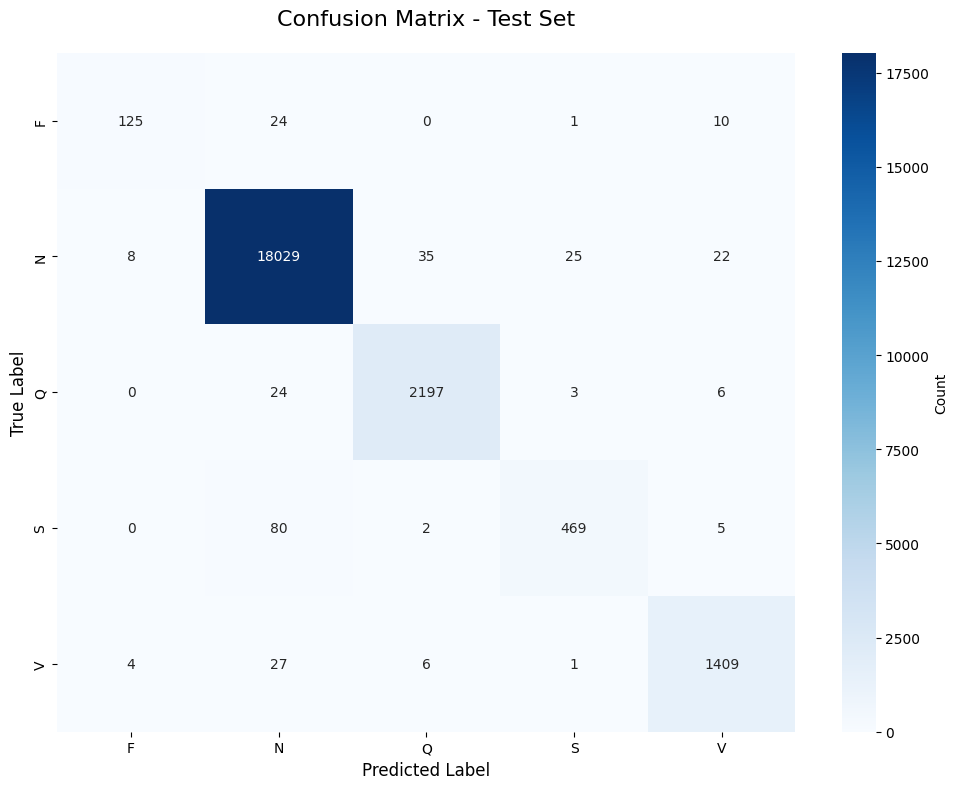

Normalized confusion matrix saved to: confusion_matrix_normalized.png


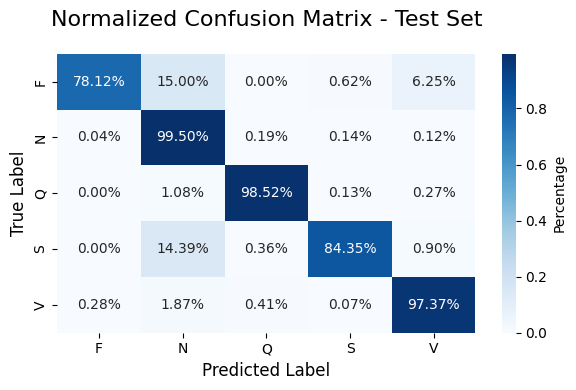

In [10]:
print("\nGenerating confusion matrix...")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
print("Confusion matrix saved to: confusion_matrix.png")
plt.show()

# Normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix - Test Set', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=150, bbox_inches='tight')
print("Normalized confusion matrix saved to: confusion_matrix_normalized.png")
plt.show()



Visualizing sample predictions...
Sample predictions saved to: sample_predictions.png


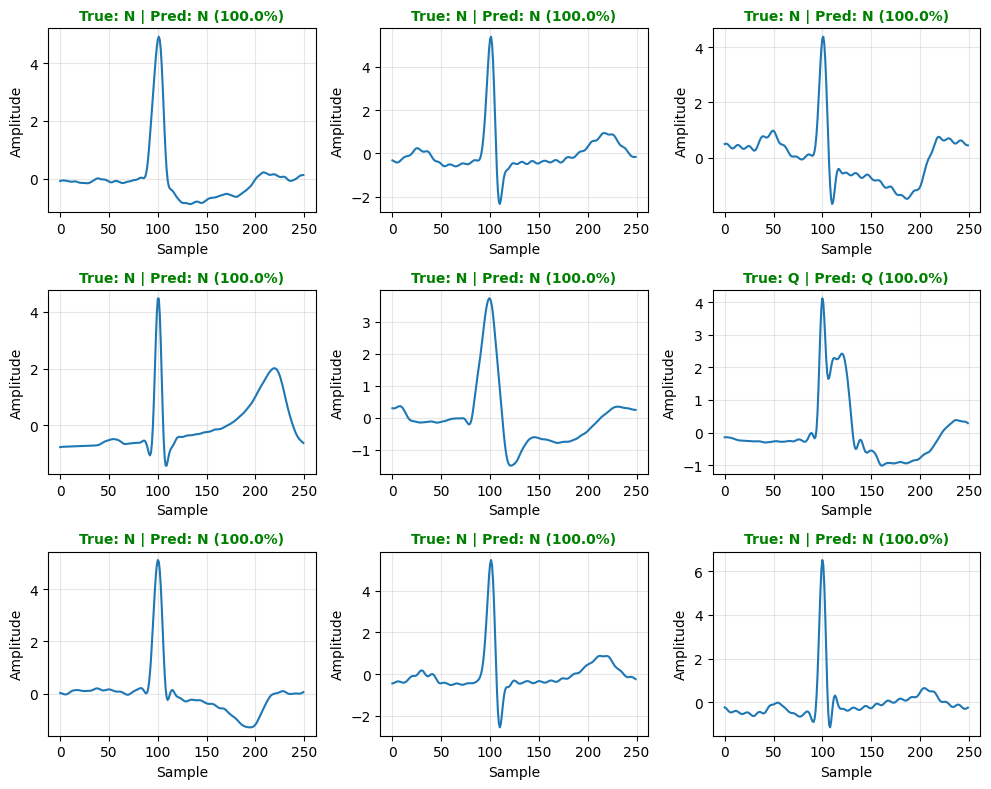

In [11]:
print("\nVisualizing sample predictions...")
num_samples = min(9, len(X_test))
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(10, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    true_label = label_names[y_true[idx]]
    pred_label = label_names[y_pred[idx]]
    confidence = y_pred_probs[idx][y_pred[idx]] * 100

    axes[i].plot(X_test[idx, :, 0])

    color = 'green' if true_label == pred_label else 'red'
    axes[i].set_title(f'True: {true_label} | Pred: {pred_label} ({confidence:.1f}%)',
                     color=color, fontsize=10, fontweight='bold')
    axes[i].set_xlabel('Sample')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
print("Sample predictions saved to: sample_predictions.png")
plt.show()